In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Conv2D, Dense, BatchNormalization, 
                                     BatchNormalization, Flatten,  Reshape,
                                     Conv2DTranspose)

2023-08-17 22:17:11.638853: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/umashukla/Documents/FlowerGen/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def discriminator_model():
  discriminator = Sequential(name="Discriminator")
  discriminator.add(Conv2D(32, kernel_size=3, name="Conv_1", strides=2, activation='leaky_relu', input_shape=(256, 256, 3), padding="same"))
  discriminator.add(Conv2D(64, kernel_size=3, strides=2, name="Conv_2", activation='leaky_relu', padding="same"))
  discriminator.add(BatchNormalization(name="BN_1"))
  discriminator.add(Conv2D(128, kernel_size=3, strides=2, name="Conv_3", activation='leaky_relu', padding="same"))
  discriminator.add(BatchNormalization(name="BN_2"))
  discriminator.add(Conv2D(256, kernel_size=3, strides=2, name="Conv_4", activation='leaky_relu', padding="same"))
  discriminator.add(BatchNormalization(name="BN_3"))
  discriminator.add(Conv2D(512, kernel_size=3, strides=2, name="Conv_5", activation='leaky_relu', padding="same"))
  discriminator.add(BatchNormalization(name="BN_4"))
  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation='sigmoid'))
  discriminator.summary()
  return discriminator

In [4]:
def generator_model():
  generator = Sequential(name="Generator")
  generator.add(Dense(128 * 32 * 32, input_shape=(9, )))
  generator.add(Reshape((32, 32, 128)))
  generator.add(Conv2DTranspose(64, kernel_size=3, strides=2, name="ConvTr_1", padding='same', activation="relu"))
  generator.add(BatchNormalization(name="BN_1"))
  generator.add(Conv2DTranspose(32, kernel_size=3, strides=2, name="ConvTr_2", padding='same', activation="relu"))
  generator.add(BatchNormalization(name="BN_2"))
  generator.add(Conv2DTranspose(16, kernel_size=3, strides=1, name="ConvTr_3", padding='same', activation="relu"))
  generator.add(BatchNormalization(name="BN_3"))
  generator.add(Conv2DTranspose(3, kernel_size=3, strides=2, name="ConvTr_4", padding='same', activation="tanh"))
  generator.summary()

  return generator

In [5]:
discriminator = discriminator_model()
generator = generator_model()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 Conv_2 (Conv2D)             (None, 64, 64, 64)        18496     
                                                                 
 BN_1 (BatchNormalization)   (None, 64, 64, 64)        256       
                                                                 
 Conv_3 (Conv2D)             (None, 32, 32, 128)       73856     
                                                                 
 BN_2 (BatchNormalization)   (None, 32, 32, 128)       512       
                                                                 
 Conv_4 (Conv2D)             (None, 16, 16, 256)       295168    
                                                                 
 BN_3 (BatchNormalization)   (None, 16, 16, 256)     

In [6]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [7]:
def GAN_model(generator, discriminator):
  GAN = Sequential(name="GAN")
  discriminator.trainable = False
  GAN.add(generator)
  GAN.add(discriminator)

  return GAN

In [8]:
GAN = GAN_model(generator, discriminator)

In [9]:
GAN.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001))

In [10]:
def train(epochs, batch_size=128, save_interval=50):
  real = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for epoch in range(epochs):
    index = np.random.randint(0, 3670 , batch_size)
    images = flowers_train[index]
    noise = np.random.normal(0, 1, (batch_size, 9))
    gen_images = generator.predict(noise)
    d_loss_real = discriminator.train_on_batch(images, real)
    d_loss_fake = discriminator.train_on_batch(gen_images, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    g_loss = GAN.train_on_batch(noise, real)

    if epoch % save_interval == 0:
      plot_generated_images(generator)

In [11]:
def plot_generated_images(generator, image_grid_rows=3, image_grid_columns=3):

  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, 9))
  generated_images = generator.predict(z)
  generated_images = 0.5 * generated_images + 0.5
  fig, ax = plt.subplots(image_grid_rows, image_grid_columns,
                         figsize=(3, 3), sharey=True, sharex=True)
  
  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      ax[i, j].imshow(generated_images[cnt, :, :, 0])
      ax[i, j].axis('off')
      cnt += 1

In [12]:
dataset, info = tfds.load('tf_flowers', split='train', with_info=True)

def preprocess(example):
  image = example['image']
  image = tf.image.resize(image, [256, 256])
  image = tf.cast(image, tf.float32) / 255.0
  return image

images = []
for example in dataset:
  image = preprocess(example)
  images.append(image.numpy())
flowers_train = np.array(images)

print(flowers_train.shape) 

(3670, 256, 256, 3)


1/1 [==============================] - 1s 689ms/step


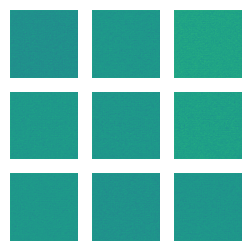

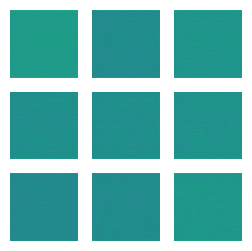

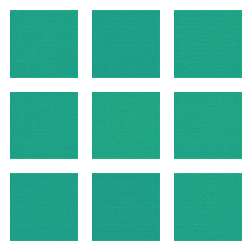

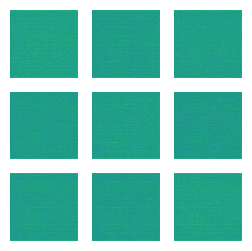

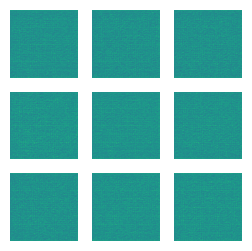

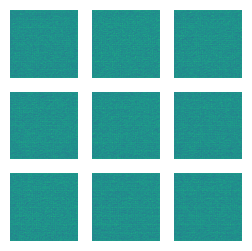

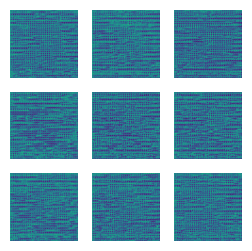

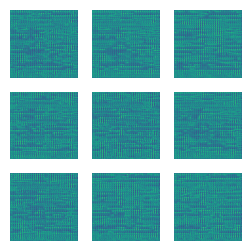

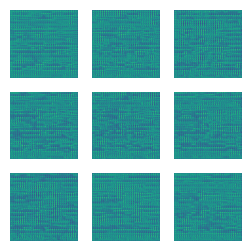

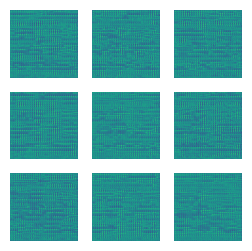

In [13]:
train(epochs=1000, batch_size=32, save_interval=100)